License

```
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
```

# Using CompilerGym environments with RLlib

In this notebook we will use [RLlib](https://docs.ray.io/en/master/rllib.html) to train an agent for CompilerGym's [LLVM environment](https://facebookresearch.github.io/CompilerGym/llvm/index.html). RLlib is a popular library for scalable reinforcement learning, built on [Ray](https://docs.ray.io/en/master/index.html). It provides distributed implementations of several standard reinforcement learning algorithms.

Our goal is not to produce the best agent, but to demonstrate how to integrate CompilerGym with RLlib. It will take about 20 minutes to work through. Let's get started!

## Installation

We'll begin by installing the `compiler_gym` and `ray` packages:

In [12]:
!pip install compiler_gym 'ray[default,rllib]' &>/dev/null || echo "Install failed!"

# Print the versions of the libraries that we are using:
import compiler_gym
import ray

print("compiler_gym version:", compiler_gym.__version__)
print("ray version:", ray.__version__)

compiler_gym version: 0.2.3
ray version: 1.9.0


## Defining an Environment

Next we will define the environment to use for our experiments. For the purposes of a simple demo we will apply two simplifying constraints to CompilerGym's LLVM environment:

1. We will use only a small subset of the command line flag action space.
2. We will clip the length of episodes to a maximum number of steps.

To make things simple we will define a `make_env()` helper function to create our environment, and use the [compiler_gym.wrappers](https://facebookresearch.github.io/CompilerGym/compiler_gym/wrappers.html) API to implement these constraints. There is quite a lot going on in this cell, be sure to read through the comments for an explanation of what is going on!

In [13]:
import sys
import os
os.environ.setdefault("COMPILER2_ROOT", "/home/dx4/tools/compiler2")



'/home/dx4/tools/compiler2'

In [14]:
from compiler_gym.spaces import Reward
from compiler_gym.third_party import llvm
from compiler_gym.util.logging import init_logging
from compiler_gym.util.registration import register
from compiler_gym.util.runfiles_path import runfiles_path, site_data_path
from compiler_gym.service.connection import ServiceError
import compiler2_service.paths

In [15]:
from compiler_gym.envs.llvm.datasets import (
    AnghaBenchDataset,
    BlasDataset,
    CBenchDataset,
    CBenchLegacyDataset,
    CBenchLegacyDataset2,
    CHStoneDataset,
    CsmithDataset,
    NPBDataset,
)

import compiler2_service
from compiler2_service.agent_py.rewards import perf_reward, runtime_reward
from compiler2_service.agent_py.datasets import poj104, hpctoolkit_dataset


def register_env():
    register(
        id="compiler2-v0",
        entry_point=compiler2_service.HPCToolkitCompilerEnv,
        kwargs={
            "service": compiler2_service.paths.COMPILER2_SERVICE_PY,
            "rewards": [ perf_reward.RewardTensor(),
                         runtime_reward.RewardTensor()
            ],
            "datasets": [
                hpctoolkit_dataset.Dataset(),
                CBenchDataset(site_data_path("llvm-v0")),
                CsmithDataset(site_data_path("llvm-v0"), sort_order=0),
                NPBDataset(site_data_path("llvm-v0"), sort_order=0),
                BlasDataset(site_data_path("llvm-v0"), sort_order=0),
                AnghaBenchDataset(site_data_path("llvm-v0"), sort_order=0),
                CHStoneDataset(site_data_path("llvm-v0"), sort_order=0),
            ],
        },
    )

# register_env()

In [16]:
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit
from ray import tune
def make_env() -> compiler_gym.envs.CompilerEnv:
    """Make the reinforcement learning environment for this experiment."""
    # We will use LLVM as our base environment. Here we specify the observation
    # space from this paper: https://arxiv.org/pdf/2003.00671.pdf and the total
    # IR instruction count as our reward space, normalized against the
    # performance of LLVM's -Oz policy.
    
    # env = compiler_gym.make(
    #     "llvm-v0",
    #     observation_space="Autophase",
    #     reward_space="IrInstructionCountOz",
    # )

    # env = compiler_gym.make(
    #     "compiler2-v0",
    #     observation_space="runtime",
    #     reward_space="runtime"
    # )
    
    env = compiler2_service.make(
        "compiler2-v0",
        observation_space="perf",
        reward_space="perf"
    )

    # Here we constrain the action space of the environment to use only a
    # handful of command line flags from the full set. We do this to speed up
    # learning by pruning the action space by hand. This also limits the
    # potential improvements that the agent can achieve compared to using the
    # full action space.
    # env = ConstrainedCommandline(env, flags=[
    #     "-break-crit-edges",
    #     "-early-cse-memssa",
    #     "-gvn-hoist",
    #     "-gvn",
    #     "-instcombine",
    #     "-instsimplify",
    #     "-jump-threading",
    #     "-loop-reduce",
    #     "-loop-rotate",
    #     "-loop-versioning",
    #     "-mem2reg",
    #     "-newgvn",
    #     "-reg2mem",
    #     "-simplifycfg",
    #     "-sroa",
    # ])
    # Finally, we impose a time limit on the environment so that every episode
    # for 5 steps or fewer. This is because the environment's task is continuous
    # and no action is guaranteed to result in a terminal state. Adding a time
    # limit means we don't have to worry about learning when an agent should
    # stop, though again this limits the potential improvements that the agent
    # can achieve compared to using an unbounded maximum episode length.
    env = TimeLimit(env, max_episode_steps=5)
    return env

In [17]:
# Let's create an environment and print a few attributes just to check that we 
# have everything set up the way that we would like.
with make_env() as env:
    print("Action space:", env.action_space)
    print("Observation space:", env.observation_space)
    print("Reward space:", env.reward_space)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 

Action space: Commandline([-add-discriminators -adce -aggressive-instcombine -alignment-from-assumptions -always-inline -argpromotion -attributor -barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge -constprop -coro-cleanup -coro-early -coro-elide -coro-split -correlated-propagation -cross-dso-cfi -deadargelim -dce -die -dse -reg2mem -div-rem-pairs -early-cse-memssa -early-cse -elim-avail-extern -ee-instrument -flattencfg -float2int -forceattrs -inline -insert-gcov-profiling -gvn-hoist -gvn -globaldce -globalopt -globalsplit -guard-widening -hotcoldsplit -ipconstprop -ipsccp -indvars -irce -infer-address-spaces -inferattrs -inject-tli-mappings -instsimplify -instcombine -instnamer -jump-threading -lcssa -licm -libcalls-shrinkwrap -load-store-vectorizer -loop-data-prefetch -loop-deletion -loop-distribute -loop-fusion -loop-guard-widening -loop-idiom -loop-instsimplify -loop-interchange -loop-load-elim -

## Datasets

Now that we have an environment, we will need a set of programs to train on. In CompilerGym, these programs are called *benchmarks*. CompilerGym ships with [several sets of benchmarks](https://facebookresearch.github.io/CompilerGym/llvm/index.html#datasets). Here we will take a handful of benchmarks from the `npb-v0` dataset for training. We will then further divide this set into training and validation sets. We will use `chstone-v0` as a holdout test set.

In [18]:
from itertools import islice

with make_env() as env:
  # The two datasets we will be using:
  hpc_bench = env.datasets["benchmark://hpctoolkit-cpu-v0"]
  chstone = env.datasets["chstone-v0"]

  # Each dataset has a `benchmarks()` method that returns an iterator over the
  # benchmarks within the dataset. Here we will use iterator sliceing to grab a 
  # handful of benchmarks for training and validation.
  train_benchmarks = list(islice(hpc_bench.benchmarks(), 4))
  train_benchmarks, val_benchmarks = train_benchmarks[:2], train_benchmarks[2:]
  # We will use the entire chstone-v0 dataset for testing.
  test_benchmarks = list(hpc_bench.benchmarks())

print("Number of benchmarks for training:", len(train_benchmarks))
print("Number of benchmarks for validation:", len(val_benchmarks))
print("Number of benchmarks for testing:", len(test_benchmarks))

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 

Number of benchmarks for training: 2
Number of benchmarks for validation: 2
Number of benchmarks for testing: 4


## Registering the environment with RLlib

Now that we have our environment and training benchmarks, we can register the environment for use with RLlib. To do this we will define a second `make_training_env()` helper that uses the [CycleOverBenchmarks](https://facebookresearch.github.io/CompilerGym/compiler_gym/wrappers.html#compiler_gym.wrappers.CycleOverBenchmarks) wrapper to ensure that the environment uses all of the training benchmarks. We then call `tune.register_env()`, assining the environment a name.

In [19]:
from compiler_gym.wrappers import CycleOverBenchmarks

def make_training_env(*args) -> compiler_gym.envs.CompilerEnv:
  """Make a reinforcement learning environment that cycles over the
  set of training benchmarks in use.
  """
  del args  # Unused env_config argument passed by ray
  return CycleOverBenchmarks(make_env(), train_benchmarks)

tune.register_env("compiler_gym", make_training_env)

In [20]:
# Lets cycle through a few calls to reset() to demonstrate that this environment
# selects a new benchmark for each episode.
with make_training_env() as env:
  env.reset()
  print(env.benchmark)
  env.reset()
  print(env.benchmark)
  env.reset()
  print(env.benchmark)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 


 /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f 

source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.bc



 pre_run_cmd: 
[]



 run_cmd: 
/dev/shm/compiler_gym_dx4/s/0406T133423-665847-0b5f/benchmark.exe


hackkk: -O0
perf
Reward Runtime: reset
runtime_tensor
real 1.08
user 1.07
sys 0.00

real 1.09
user 1.08
sys 0.00

real 1.08
user 1.07
sys 0.00

real 1.09
user 1.0

## Run the training loop

Now that we have the environment set up, let's run a training loop. Here will use RLlib's [Proximal Policy Optimization](https://docs.ray.io/en/master/rllib-algorithms.html#ppo) implementation, and run a very short training loop just for demonstative purposes.

In [21]:
import compiler_gym.util.runfiles_path as path

print(path.runfiles_path("."))
print(path.site_data_path("."))
print(path.cache_path("."))
print(path.transient_cache_path("."))

/home/dx4/tools/miniconda3/lib/python3.8/site-packages
/home/dx4/.local/share/compiler_gym
/home/dx4/.cache/compiler_gym
/dev/shm/compiler_gym_dx4


In [22]:
import ray
from ray.rllib.algorithms.ppo import PPOTrainer

# (Re)Start the ray runtime.
if ray.is_initialized():
  ray.shutdown()
ray.init(include_dashboard=False, ignore_reinit_error=True)

tune.register_env("compiler_gym", make_training_env)

analysis = tune.run(
    PPOTrainer,
    checkpoint_at_end=True,
    stop={
        "episodes_total": 5,
    },
    config={
        "seed": 0xCC,
        "num_workers": 1,
        # Specify the environment to use, where "compiler_gym" is the name we 
        # passed to tune.register_env().
        "env": "compiler_gym",
        # Reduce the size of the batch/trajectory lengths to match our short 
        # training run.
        "rollout_fragment_length": 5,
        "train_batch_size": 5,
        "sgd_minibatch_size": 5,
    }
)

Trial name,status,loc
PPO_compiler_gym_47e50_00000,PENDING,


(PPO pid=4033683) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(PPO pid=4033683) Is that file:  True


(PPO pid=4033683) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=4033683) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=4033683) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=4033683) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=4033683) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=4033683) /h

(RolloutWorker pid=4033696) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=4033696) Is that file:  True


(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/co

(RolloutWorker pid=4033696) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=4033696) Is that file:  True


(RolloutWorker pid=4033696) Using backend: pytorch
(RolloutWorker pid=4033696) ./compiler_gym-llvm-service: /lib64/libtinfo.so.5: no version information available (required by ./compiler_gym-llvm-service)


(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.c"
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  compile: 
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.ll
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.exe
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f3

(RolloutWorker pid=4033696) 2022-04-06 13:35:24,709	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
(PPO pid=4033683) 2022-04-06 13:35:25,530	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


Trial name,status,loc
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683


(PPO pid=4033683) 2022-04-06 13:35:26,020	INFO trainable.py:124 -- Trainable.setup took 16.466 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=4033683) 2022-04-06 13:35:26,020	WARNING util.py:57 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.c"
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  compile: 
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.ll
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.exe
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f3

Trial name,status,loc
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683


(RolloutWorker pid=4033696) Reward Runtime: reset
(RolloutWorker pid=4033696) runtime_tensor
(RolloutWorker pid=4033696) real 0.34
(RolloutWorker pid=4033696) user 0.34
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 0.34
(RolloutWorker pid=4033696) user 0.34
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 0.34
(RolloutWorker pid=4033696) user 0.34
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 0.34
(RolloutWorker pid=4033696) user 0.34
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 0.34
(RolloutWorker pid=4033696) user 0.33
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) hackkk: -loop-predication
(RolloutWorker pid=4033696) perf
(RolloutWorker pid=4033696) hackkk: -name-anon-globals
(RolloutWorker pid=4033696) hackkk: -loop-rotate
(Rollo

Trial name,status,loc
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683


(RolloutWorker pid=4033696) hackkk: -lcssa
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.c"
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  compile: 
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.ll
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.exe
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark_new.ll /dev/sh

Trial name,status,loc
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683


(RolloutWorker pid=4033696) Reward Runtime: reset
(RolloutWorker pid=4033696) runtime_tensor
(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.07
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.07
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.08
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.09
(RolloutWorker pid=4033696) user 1.09
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 


Trial name,status,loc
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683


(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.07
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
Result for PPO_compiler_gym_47e50_00000:
  agent_timesteps_total: 5
  custom_metrics: {}
  date: 2022-04-06_13-35-42
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.005464213017474231
  episode_reward_mean: 0.005464213017474231
  episode_reward_min: 0.005464213017474231
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: de9ea7c860aa44ef97ed7b15ce3b576f
  hostname: ufront.cs.rice.edu
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 4.819715976715088
          entropy_coeff: 0.0
          kl: 0.0004882592475041747
          model: {}
          policy_loss: -0.10469101369380951
          total_loss: -0.10458077490329742
          vf_explained_var: 1.192092913271

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,1,16.8137,5,0.00546421,0.00546421,0.00546421,5


(RolloutWorker pid=4033696) hackkk: -consthoist
(RolloutWorker pid=4033696) hackkk: -loop-unroll-and-jam


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,1,16.8137,5,0.00546421,0.00546421,0.00546421,5


(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.c"
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  compile: 
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.ll
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.exe
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f3

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,1,16.8137,5,0.00546421,0.00546421,0.00546421,5


Result for PPO_compiler_gym_47e50_00000:
  agent_timesteps_total: 10
  custom_metrics: {}
  date: 2022-04-06_13-35-57
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.027506845314330494
  episode_reward_mean: 0.016485529165902364
  episode_reward_min: 0.005464213017474231
  episodes_this_iter: 1
  episodes_total: 2
  experiment_id: de9ea7c860aa44ef97ed7b15ce3b576f
  hostname: ufront.cs.rice.edu
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 4.817491054534912
          entropy_coeff: 0.0
          kl: 0.001025678007863462
          model: {}
          policy_loss: -0.1413041055202484
          total_loss: -0.1411057412624359
          vf_explained_var: -1.1523564324988911e-07
          vf_loss: 9.579134348314255e-05
    num_agent_steps_sampled: 10
    num_agent_steps_trained: 10
    num_steps_sampled: 10
   

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,2,31.886,10,0.0164855,0.0275068,0.00546421,5


(RolloutWorker pid=4033696) perf
(RolloutWorker pid=4033696) Reward Runtime: reset
(RolloutWorker pid=4033696) runtime_tensor
(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.08
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,2,31.886,10,0.0164855,0.0275068,0.00546421,5


(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.07
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.07
(RolloutWorker pid=4033696) user 1.07
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.09
(RolloutWorker pid=4033696) user 1.08
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.08
(RolloutWorker pid=4033696) user 1.08
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
Result for PPO_compiler_gym_47e50_00000:
  agent_timesteps_total: 15
  custom_metrics: {}
  date: 2022-04-06_13-36-11
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.027506845314330494
  episode_reward_mean: 0.009462250449799972
  episode_reward_min: -0.004584306982404812
  episodes_this_iter: 1
  episodes_total: 3
  experiment_id: de9ea7c860aa44ef97ed7b15ce3b576f
  hostname: ufront.cs.rice.edu


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,3,45.3246,15,0.00946225,0.0275068,-0.00458431,5


(RolloutWorker pid=4033696) hackkk: -loop-simplifycfg
(RolloutWorker pid=4033696) hackkk: -deadargelim


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,3,45.3246,15,0.00946225,0.0275068,-0.00458431,5


(RolloutWorker pid=4033696) hackkk: -instsimplify
(RolloutWorker pid=4033696) hackkk: -strip-debug-declare


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,3,45.3246,15,0.00946225,0.0275068,-0.00458431,5


(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.c"
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  compile: 
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.ll
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.exe
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f3

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,4,60.5574,20,0.00184731,0.0275068,-0.0209975,5


(RolloutWorker pid=4033696) hackkk: -slsr
(RolloutWorker pid=4033696) hackkk: -infer-address-spaces
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.c"
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696)  compile: 
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.ll
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133513-532391-6f35/benchmark.exe
(RolloutWorker pid=4033696) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_g

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,4,60.5574,20,0.00184731,0.0275068,-0.0209975,5


(RolloutWorker pid=4033696) Reward Runtime: reset
(RolloutWorker pid=4033696) runtime_tensor
(RolloutWorker pid=4033696) real 1.09
(RolloutWorker pid=4033696) user 1.09
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.10
(RolloutWorker pid=4033696) user 1.09
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
(RolloutWorker pid=4033696) real 1.10
(RolloutWorker pid=4033696) user 1.09
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,RUNNING,128.42.128.60:4033683,4,60.5574,20,0.00184731,0.0275068,-0.0209975,5


(RolloutWorker pid=4033696) real 1.09
(RolloutWorker pid=4033696) user 1.09
(RolloutWorker pid=4033696) sys 0.00
(RolloutWorker pid=4033696) 
Result for PPO_compiler_gym_47e50_00000:
  agent_timesteps_total: 25
  custom_metrics: {}
  date: 2022-04-06_13-36-40
  done: true
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.027506845314330494
  episode_reward_mean: 0.0021490633987277154
  episode_reward_min: -0.020997503296242365
  episodes_this_iter: 1
  episodes_total: 5
  experiment_id: de9ea7c860aa44ef97ed7b15ce3b576f
  hostname: ufront.cs.rice.edu
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.012500000186264515
          cur_lr: 4.999999873689376e-05
          entropy: 4.798734188079834
          entropy_coeff: 0.0
          kl: 0.0024173103738576174
          model: {}
          policy_loss: -0.18789276480674744
          total_loss: -0.1878124624490738
          vf_explained_var: 7.1525576572

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_47e50_00000,TERMINATED,128.42.128.60:4033683,5,74.3235,25,0.00214906,0.0275068,-0.0209975,5


2022-04-06 13:36:41,684	INFO tune.py:626 -- Total run time: 95.15 seconds (93.98 seconds for the tuning loop).


## Evaluate the agent

After running the training loop we can create a new agent that has exploration disabled, restore it from the training checkpoint, and then use it for running inference tests.

In [23]:
agent = PPOTrainer(
    env="compiler_gym",
    config={
        "num_workers": 1,
        "seed": 0xCC,
        # For inference we disable the stocastic exploration that is used during 
        # training.
        "explore": False,
    },
)

# We only made a single checkpoint at the end of training, so restore that. In
# practice we may have many checkpoints that we will select from using 
# performance on the validation set.
checkpoint = analysis.get_best_checkpoint(
    metric="episode_reward_mean", 
    mode="max", 
    trial=analysis.trials[0]
)

agent.restore(checkpoint)

2022-04-06 13:37:12,203	INFO trainer.py:722 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also want to then set `eager_tracing=True` in order to reach similar execution speed as with static-graph mode.
2022-04-06 13:37:12,204	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-06 13:37:12,205	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=4033692) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=4033692) Is that file:  True


(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/co

(RolloutWorker pid=4033692) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=4033692) Is that file:  True


(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/co

(RolloutWorker pid=4033692) 
(RolloutWorker pid=4033692)  /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35 
(RolloutWorker pid=4033692) 
(RolloutWorker pid=4033692) source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35/benchmark.c"
(RolloutWorker pid=4033692) 
(RolloutWorker pid=4033692) 
(RolloutWorker pid=4033692)  compile: 
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35/benchmark.ll
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35/benchmark.exe
(RolloutWorker pid=4033692) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133715-459211-6f3

(RolloutWorker pid=4033692) 2022-04-06 13:37:26,453	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-04-06 13:37:27,581	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-04-06 13:37:28,076	INFO trainable.py:124 -- Trainable.setup took 15.874 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-04-06 13:37:28,077	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-04-06 13:37:28,132	INFO trainable.py:467 -- Restored on 128.42.128.60 from checkpoint: /home/dx4/ray_results/PPO_2022-04-06_13-35-06/PPO_compiler_gym_47e50_00000_0_2022-04-06_13-35-06/checkpoint_000005/checkpoint-5
2022-04-06 13:37:28,133	INFO trainable.py:475 -- Current state

In [24]:
# Lets define a helper function to make it easy to evaluate the agent's 
# performance on a set of benchmarks.

def run_agent_on_benchmarks(benchmarks):
  """Run agent on a list of benchmarks and return a list of cumulative rewards."""
  with make_env() as env:
    rewards = []
    for i, benchmark in enumerate(benchmarks, start=1):
        observation, done = env.reset(benchmark=benchmark), False
        while not done:
            action = agent.compute_action(observation)
            observation, _, done, _ = env.step(action)
        rewards.append(env.episode_reward)
        print(f"[{i}/{len(benchmarks)}] {env.state}")

  return rewards

# Evaluate agent performance on the validation set.
val_rewards = run_agent_on_benchmarks(val_benchmarks)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 


 /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b 

source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.bc



 pre_run_cmd: 
[]



 run_cmd: 
/dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.exe


hackkk: -O0
perf
Reward Runtime: reset
runtime_tensor
real 0.05
user 0.00
sys 0.00

real 0.05
user 0.00
sys 0.00

real 0.05
user 0.00
sys 0.00

real 0.05
user 0.0

2022-04-06 13:37:37,643	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!


real 0.05
user 0.00
sys 0.00

hackkk: -instsimplify
perf
hackkk: -instsimplify
hackkk: -instsimplify
hackkk: -instsimplify
hackkk: -instsimplify
[1/2] benchmark='benchmark://hpctoolkit-cpu-v0/nanosleep' commandline='opt -instsimplify -instsimplify -instsimplify -instsimplify -instsimplify input.bc -o output.bc' walltime=2.025278329849243 reward=0.0666383520853629

 /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b 

source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133735-172264-659b/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T

In [25]:
# Evaluate agent performance on the holdout test set.
test_rewards = run_agent_on_benchmarks(test_benchmarks)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 


 /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36 

source_filename = "/dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt --debugify -o /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.bc /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.bc



 pre_run_cmd: 
[]



 run_cmd: 
/dev/shm/compiler_gym_dx4/s/0406T133749-107072-dc36/benchmark.exe


hackkk: -O0
perf
Reward Runtime: reset
runtime_tensor
real 1.12
user 1.11
sys 0.00

real 1.09
user 1.09
sys 0.00

real 1.10
user 1.10
sys 0.00

real 1.09
user 1.0

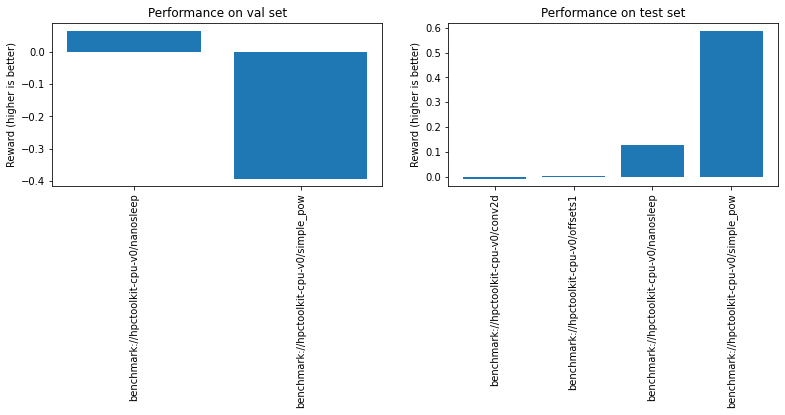

2022-04-06 20:03:21,767	WARNING worker.py:1245 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffd82d96febddd03c355ac521001000000 Worker ID: f3890386b150671cc1e7fcff40324681e95aca6793e43395a9721ac8 Node ID: 4aac504e6e221b36cd29906004180746c583dbb67d24a62c3ec6658c Worker IP address: 128.42.128.60 Worker port: 45933 Worker PID: 4033692


In [28]:
# Finally lets plot our results to see how we did!
from matplotlib import pyplot as plt

def plot_results(x, y, name, ax):
  plt.sca(ax)
  plt.bar(range(len(y)), y)
  plt.ylabel("Reward (higher is better)")
  plt.xticks(range(len(x)), x, rotation = 90)
  plt.title(f"Performance on {name} set")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 3)
plot_results(val_benchmarks, val_rewards, "val", ax1)
plot_results(test_benchmarks, test_rewards, "test", ax2)
fig.patch.set_facecolor('white')
plt.show()

That's it for this demonstration! Check out the [documentation site](https://facebookresearch.github.io/CompilerGym/) for more details, API reference, and more. If you can encounter any problems, please [file an issue](https://github.com/facebookresearch/CompilerGym/issues).